In [1]:
from sklearn.linear_model import LogisticRegression
import csv
import numpy as np
import pandas as pd
import warnings
import jieba
import jieba.posseg as pseg
from jieba import analyse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('shuju2.csv')

In [3]:
data

,留言编号,留言用户,留言主题,留言时间,留言详情,一级标签
0,24,A00074011,A市西湖建筑集团占道施工有安全隐患,2020/1/612:09:38,A3区大道西行便道，未管所路口至加油站路段，人行道包括路灯杆，被圈西湖建筑集团燕子山安置房项...,城乡建设
1,37,U0008473,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/411:17:46,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水、电等设施后，烂尾多年，用护栏围着，不但占...,城乡建设
2,83,A00063999,投诉A市A1区苑物业违规收停车费,2019/12/3017:06:14,尊敬的领导：A1区苑小区位于A1区火炬路，小区物业A市程明物业管理有限公司，未经小区业主同意...,城乡建设
3,303,U0007137,A1区蔡锷南路A2区华庭楼顶水箱长年不洗,2019/12/614:40:14,A1区A2区华庭小区高层为二次供水，楼顶水箱长年不洗，现在自来水龙头的水严重霉味，大家都知道...,城乡建设
4,319,U0007137,A1区A2区华庭自来水好大一股霉味,2019/12/511:17:22,A1区A2区华庭小区高层为二次供水，楼顶水箱长年不洗，现在自来水龙头的水严重霉味，大家都知道...,城乡建设
...,...,...,...,...,...,...
9205,11763690,U0005980,两孩子一个是一级脑瘫，能再生育吗？,2015/4/2218:46:00,我们夫妻都是农村户口，大的是女9岁，小的是儿2岁半，才15斤，治疗两年，一级脑瘫。我是纯女户...,卫生计生
9206,11977590,U0005367,B市中心医院医生不负责任，做无痛人流手术后结果还是活胚芽,2014/9/2915:16:46,本人2015年2月16号在B市中心医院做无痛人流手术，手术后还有怀孕的症状，于2015年2月...,卫生计生
9207,14697490,U0002040,西地省二胎产假新政策何时出台？,2016/2/2915:17:44,我们是再婚，很想再要一个小孩，不知我省二胎新政策何时出，如果先怀孕了，会做和处理,卫生计生
9208,15397690,U0001803,K8县惊现奇葩证明！,2016/4/178:15:17,K8县惊现奇葩证明！我是西地省K8县人，想生二孩。被告知要开证明，即“没生二孩的证明”。先写...,卫生计生


In [4]:
data['留言内容'] = data['留言主题'] + ' ' + data['留言详情']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9210 entries, 0 to 9209
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   留言编号    9210 non-null   int64 
 1   留言用户    9210 non-null   object
 2   留言主题    9210 non-null   object
 3   留言时间    9210 non-null   object
 4   留言详情    9210 non-null   object
 5   一级标签    9210 non-null   object
 6   留言内容    9210 non-null   object
dtypes: int64(1), object(6)
memory usage: 503.8+ KB


In [6]:
data['一级标签'].value_counts()

一级标签
城乡建设       2009
劳动和社会保障    1969
教育文体       1589
商贸旅游       1215
环境保护        938
卫生计生        877
交通运输        613
Name: count, dtype: int64

### 对留言内容进行文本预处理 

In [7]:
messages = list(data['留言内容'].values)
csv_filename = '留言信息.csv'

with open(csv_filename, 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # 写入留言
    for message in messages:
        writer.writerow([message])

In [8]:
# 获取停用词
def load_stopwords(stopwords_file):
    stopwords = set()
    with open(stopwords_file, 'r', encoding='utf-8') as f:
        for line in f:
            stopwords.add(line.strip())
    return stopwords

stopwords = load_stopwords('哈工大停用词表.txt')

In [9]:
# 加载文档集，对文档集过滤词性和停用词
def filter_documents(data_path, stopwords):
    documents = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            document = []
            words = pseg.cut(line.strip())
            for word, flag in words:
                if flag.startswith('n') and word not in stopwords and len(word) > 1:
                    document.append(word)
            documents.append(document)
    return documents

new_documents = filter_documents('留言信息.csv',stopwords)
len(new_documents)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/cr/ywvw0phn6pz14brg34z9p0p40000gn/T/jieba.cache
Loading model cost 0.314 seconds.
Prefix dict has been built successfully.


9210

### 处理后的展示

In [10]:
new_documents[0]

['西湖',
 '建筑',
 '集团',
 '大道',
 '加油站',
 '路段',
 '人行道',
 '路灯',
 '西湖',
 '建筑',
 '集团',
 '燕子',
 '项目',
 '围墙',
 '人流',
 '车流',
 '文明城市',
 '文明',
 '路段']

### 将留言做成TF-IDF中TfidfVectorizer要求的输入格式

In [11]:
b = []
for sentence in new_documents:
    string = ' '.join(sentence)
    b.append(string)
len(b)

9210

In [12]:
for i in range(len(b)):
    data['留言内容'][i] = b[i]

In [13]:
import gensim
from gensim.models.doc2vec import Doc2Vec
TaggededDocument = gensim.models.doc2vec.TaggedDocument
def deal(cut_sentences):
    train = []
    for i,text in enumerate(cut_sentences):
        word_list = text.split(' ')
        l = len(word_list)
        word_list[l-1] = word_list[l-1].strip()
        document = TaggededDocument(word_list,tags = [i])
        train.append(document)
    return train

In [14]:
c = deal(b)

### 数据划分

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = TfidfVectorizer()
wordmtx=vectorizer.fit_transform(b)

In [46]:
wordmtx.toarray().shape

(9210, 37548)

In [16]:
x_train,x_test, y_train, y_test = train_test_split(wordmtx,data['一级标签'],test_size=0.2, random_state=11)

### 逻辑回归分类

In [27]:
logitmodel=LogisticRegression()#定义回归模型
logitmodel.fit(x_train,y_train)#训练模型
y_pred = logitmodel.predict(x_test)

In [33]:
#使用classification_report()生成分类报告
class_names = [0,1,2,3,4,5,6]
report = classification_report(y_test, y_pred, target_names=[str(label) for label in class_names], output_dict=True)
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75       121
           1       0.89      0.93      0.91       401
           2       0.94      0.84      0.89       157
           3       0.87      0.82      0.84       257
           4       0.77      0.90      0.83       402
           5       0.92      0.94      0.93       318
           6       0.94      0.83      0.88       186

    accuracy                           0.87      1842
   macro avg       0.89      0.84      0.86      1842
weighted avg       0.88      0.87      0.87      1842



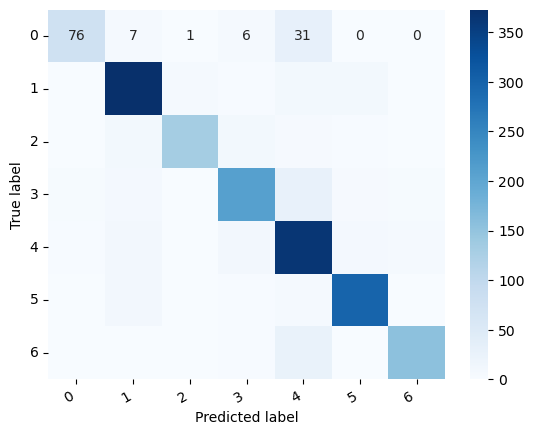

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)